In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [19]:
import csv
from scipy.optimize import *
from numpy.lib.recfunctions import *
from utils import *
from graph_score import *
from graph_precall import *

# About
We're using files from Kristina. These have been combined into one file per gear type, and converted to numpy format using kristina_to_numpy.py. In addition, rolling window std dev / avg:s have been added using add_measures.py

The new scoring is using the polynomial from a logistic regression done in Score_development.ipynb on the labeled longliner data from Alex & Chris

In [20]:
windowSize = 43200

In [21]:
def load_data(path):
    x = numpy.load(path)['x']

    x = x[x['course'] != Inf]
    x = x[x['speed'] != Inf]

    x = x[lexsort((x['timestamp'], x['mmsi']))]
    
    x = append_fields(x, 'measure_speedstddev_%s_log' % windowSize, [], dtypes='<f8', fill_value=0.0)
    x['measure_speedstddev_%s_log' % windowSize] = log10(x['measure_speedstddev_%s' % windowSize]+0.001)

    x = append_fields(x, 'measure_coursestddev_%s_log' % windowSize, [], dtypes='<f8', fill_value=0.0)
    x['measure_coursestddev_%s_log' % windowSize] = log10(x['measure_coursestddev_%s' % windowSize]+0.001)
    
    return x

In [22]:
def old_score(x, windowSize):
    # Average with magic *2 scaling
    score = (x['measure_coursestddev_%s' % windowSize] + x['measure_speedstddev_%s' % windowSize] + x['measure_speedavg_%s' % windowSize]) * 2.0 / 3.0

    # Clamp to ]0, 1[
    score = where(score < 0.0, 0.0, where(score > 1.0, 1.0, score))

    x['measure_new_score_%s' % windowSize] = score
    
def new_score(x, windowSize):
    score = zmpolynomial([x['measure_speedavg_%s' % windowSize], x['measure_speedstddev_%s_log' % windowSize], x['measure_coursestddev_%s_log' % windowSize]],
*[-125.74426718,  -41.88139409,   93.03579931,  -59.48458422,   60.9074327,
  -16.663914,    -11.64954788,   -2.25437667,   62.17203752,   -7.6389589,
   -7.60979765,   -1.73212288])

    x["measure_new_score_%s" % windowSize] = score

In [23]:
x = load_data("datasets/kristina_longliner.measures.npz")

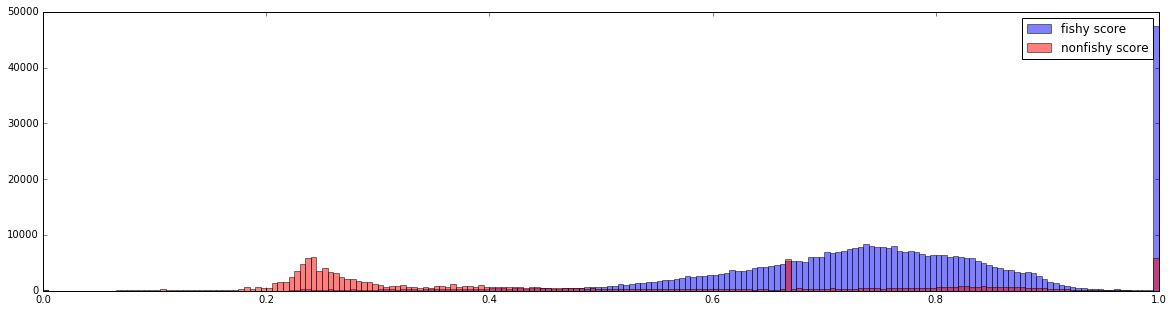

Squared numerical error: 0.130604533113
Error (overlap): 23.8615680617%
False positives given cutoff at 0.5: 21.2452712702%


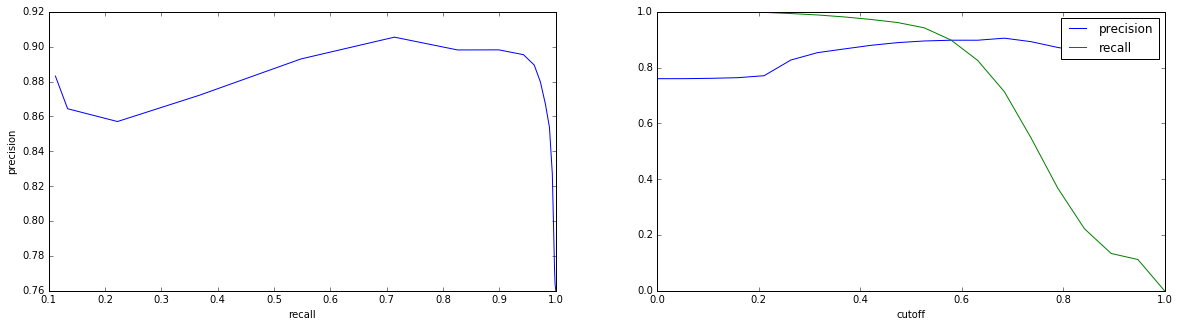

In [60]:
old_score(x, windowSize)
graph_score(x, "measure_new_score_%s" % windowSize)
graph_precall(x, "measure_new_score_%s" % windowSize)

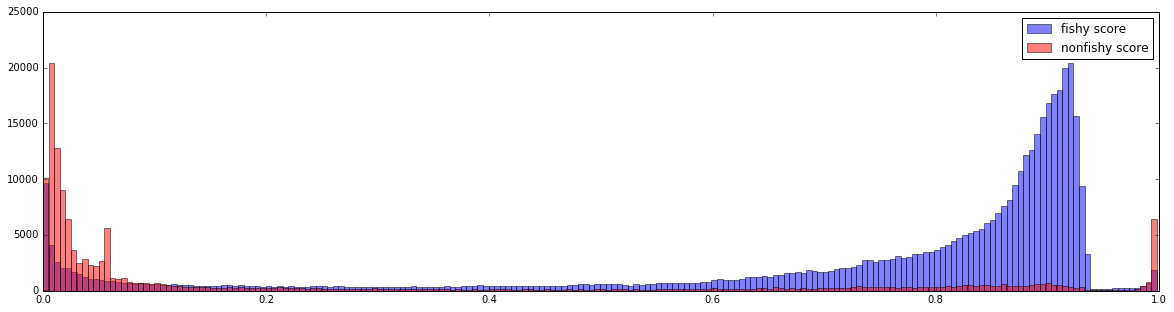

Squared numerical error: 0.149234055154
Error (overlap): 27.8422482721%
False positives given cutoff at 0.5: 14.5203933102%


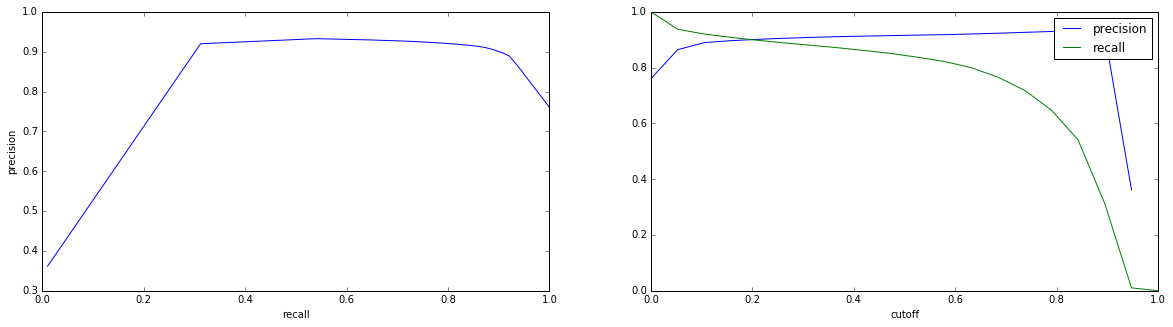

In [61]:
new_score(x, windowSize)
graph_score(x.filled(), "measure_new_score_%s" % windowSize)
graph_precall(x, "measure_new_score_%s" % windowSize)

In [62]:
x = load_data("datasets/kristina_ps.measures.npz")

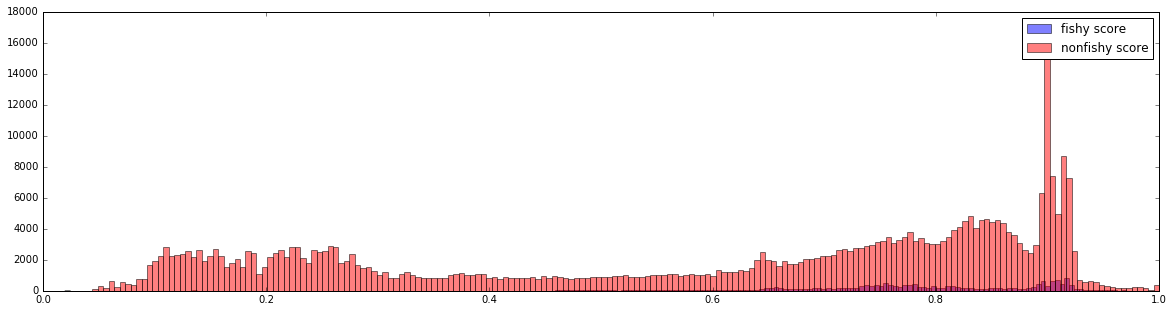

Squared numerical error: 0.418612786217
Error (overlap): 9.47813595991%
False positives given cutoff at 0.5: 13.1786239582%


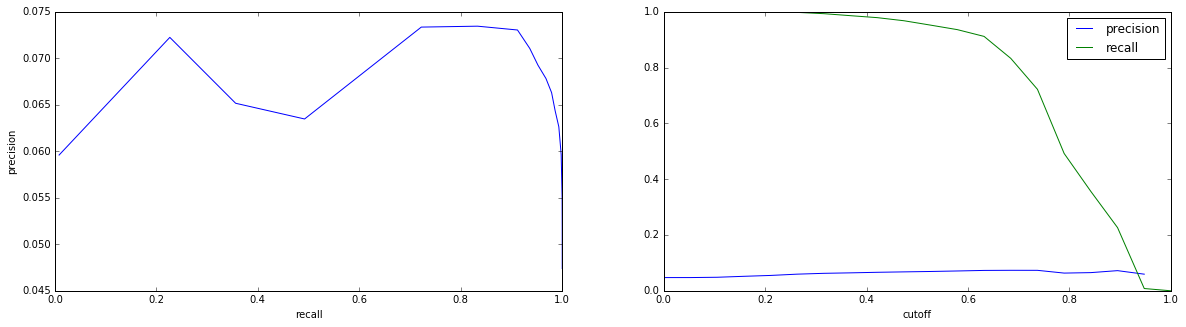

In [63]:
old_score(x, windowSize)
graph_score(x, "measure_new_score_%s" % windowSize)
graph_precall(x, "measure_new_score_%s" % windowSize)

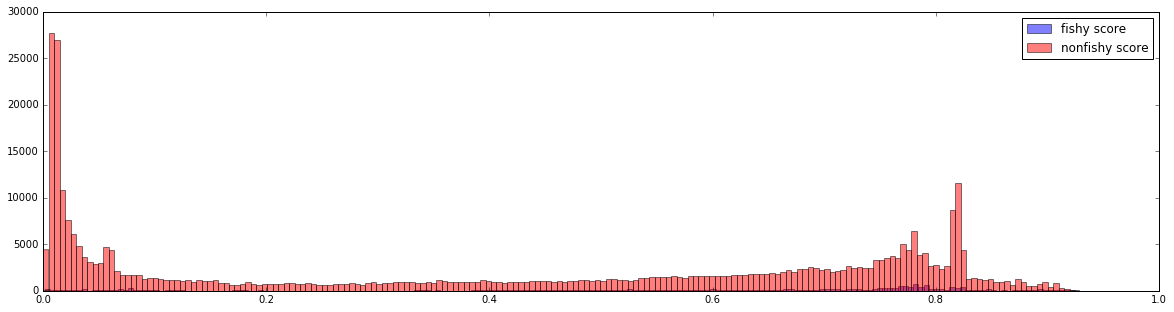

Squared numerical error: 0.274729548504
Error (overlap): 9.01786676761%
False positives given cutoff at 0.5: 13.6932026623%


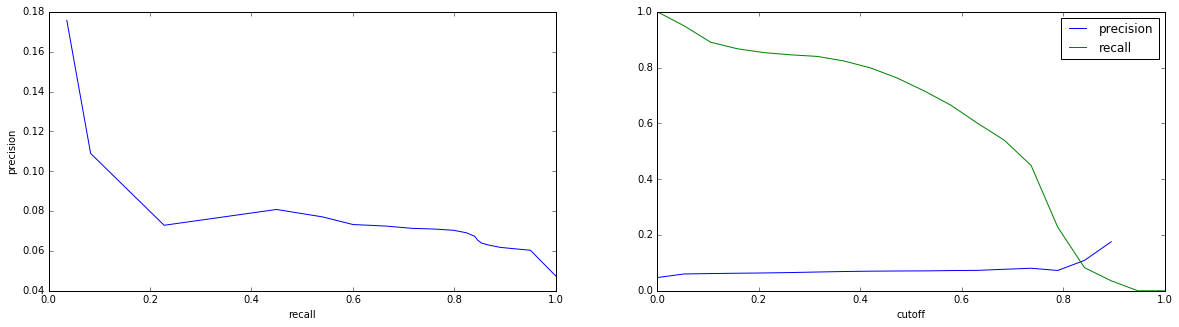

In [64]:
new_score(x, windowSize)
graph_score(x.filled(), "measure_new_score_%s" % windowSize)
graph_precall(x, "measure_new_score_%s" % windowSize)